<a href="https://colab.research.google.com/github/MrWerton/classify-student-graduation-or-evader/blob/main/classify_student_graduation_or_evader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações iniciais

In [ ]:
!pip install pandas-ods-reader


In [ ]:
import numpy as np
import pandas as pd
from pandas_ods_reader import read_ods
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Carregamento dos datasets

In [ ]:
dataframe_acarau = read_ods('/content/drive/MyDrive/Topicos Especiais/DADOS_ACARAU_2015.ods')
dataframe_iguatu = pd.read_excel('/content/drive/MyDrive/Topicos Especiais/DADOS_IGUATU.xlsx')
dataframe_quixada = pd.read_excel('/content/drive/MyDrive/Topicos Especiais/DADOS_QUIXADA.xlsx')



# Junção dos datasets

### Diferenca entre as colunas do dataset

In [ ]:
columns_acarau = set(dataframe_acarau.columns)
columns_iguatu = set(dataframe_iguatu.columns)
columns_quixada = set(dataframe_quixada.columns)


columns_commom = columns_acarau.intersection(columns_iguatu).intersection(columns_quixada)


columns_exclusive_acarau = columns_acarau - columns_commom
columns_exclusive_iguatu = columns_iguatu - columns_commom
columns_exclusive_quixada = columns_quixada - columns_commom


columns_acarau_iguatu = columns_acarau.intersection(columns_iguatu) - columns_commom
columns_acarau_quixada = columns_acarau.intersection(columns_quixada) - columns_commom
columns_iguatu_quixada = columns_iguatu.intersection(columns_quixada) - columns_commom


data = {
    "Type": ["Common", "Exclusive Acarau", "Exclusive Iguatu", "Exclusive Quixada",
             "Common Acarau and Iguatu", "Common Acarau and Quixada", "Common Iguatu and Quixada"],
    "Columns": [
        list(columns_commom),
        list(columns_exclusive_acarau),
        list(columns_exclusive_iguatu),
        list(columns_exclusive_quixada),
        list(columns_acarau_iguatu),
        list(columns_acarau_quixada),
        list(columns_iguatu_quixada)
    ]
}

df = pd.DataFrame(data)
df.head()

,Type,Columns
0,Common,"[Data Final Período, Modalidade de Ensino, Cam..."
1,Exclusive Acarau,[unnamed.1]
2,Exclusive Iguatu,"[Separar dados por: , Qtde Matriculados (em cu..."
3,Exclusive Quixada,"[Separar dados por: , Qtde Matriculados (em cu..."
4,Common Acarau and Iguatu,[]


### Interseção entre os datasets

In [ ]:
common_columns = dataframe_acarau.columns.intersection(dataframe_iguatu.columns).intersection(dataframe_quixada.columns)

df = pd.concat([dataframe_acarau[common_columns], dataframe_quixada[common_columns], dataframe_iguatu[common_columns]], axis=0)

df.head()

,Fluxo Escolar - Label,Campus (Nome),Curso+Modalidade,Matrícula retida?,Ingressantes em (Período Letivo),Modalidade de Ensino,Modalidade do Curso,Nível de Ensino,Período Letivo,Tipo de Modalidade (grupo),Campus,Cidade Aluno,Cód. da Matriz,Cód. do Curso,Data Final Período,Data Início Período,Data Última Alteração Matrícula,Dt Ref Início Matrícula,Dt Ref Início Período Letivo,Estado Aluno,Estrutura Etária,Etnia,Faixa Etária,Forma de Ingresso,Forma de Oferta (grupo),Ingressantes em (Ano Letivo),Município do Campus,"Município, UF",Nivel de Ensino - sem hierar,Num Seq deste Período Letivo,Periodo Letivo (Num),Previsão de Término (Letivo),Reserva vaga,Sexo,Tipo de Modalidade,Tipo_Escola_Origem,É ingressante?,É ingressante? (rótulo),É matrícula retida neste período letivo?,Última Alteração de Situação,CH,CH. Disc. Obrigatórias,CH. Disc. Optativas,Duracao curso,Idade (Hoje),Periodos Cursados,Período Letivo da Mudança de Situação
0,Em Curso,Acaraú,LÍNGUA INGLESA,Dentro do prazo,20192.0,Presencial,Fic,Básico,2019/2,None,CAMPUS ACARAÚ,Acaraú,7277.0,111024.0,2020-04-08,2019-11-04,2019-11-07,2019-01-07,2019-01-07,CE,Adulto (20 a 59 anos),Não dispõe da informação,35 a 39 anos,Seleção Extensão,Fic,2019.0,ACARAÚ,"Acaraú, CE",Básico,1.0,20192.0,2020/1,Não possui,F,None,E,Sim,Ingressante,Não Retida,2019-11-07,160.0,160.0,0.0,2.0,35.0,1.0,2019/2
1,Evadidos,Acaraú,TÉCNICO EM AQUICULTURA (Subsequente),Dentro do prazo,20151.0,Presencial,Subsequente,Técnico,2015/2,Educação Profissional,CAMPUS ACARAÚ,Acaraú,5158.0,11200.0,2016-06-22,2016-01-25,2016-02-26T11:13:00,2015-01-01,2015-01-07,CE,Adulto (20 a 59 anos),Amarela,25 a 29 anos,Seleção Técnico,Subsequente,2015.0,ACARAÚ,"Acaraú, CE",Técnico,1.0,20152.0,2016/2,Ampla Concorrência,F,Educação Profissional,E,Não,Veterano,Não Retida,2016-02-26,1240.0,1240.0,0.0,4.0,28.0,2.0,2015/2
2,Formados,Acaraú,XADREZ BÁSICO,Dentro do prazo,20172.0,Presencial,Fic,Básico,2017/2,None,CAMPUS ACARAÚ,Acaraú,10126.0,111030.0,2018-06-12,2018-01-24,2018-05-16,2017-01-07,2017-01-07,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Seleção Extensão,Fic,2017.0,ACARAÚ,"Acaraú, CE",Básico,1.0,20172.0,2017/2,Não possui,M,None,E,Sim,Ingressante,Não Retida,2018-05-16,60.0,60.0,0.0,1.0,22.0,1.0,2017/2
3,Formados,Acaraú,TÉCNICO EM EVENTOS (Subsequente),Fora do prazo,20172.0,Presencial,Subsequente,Técnico,2017/2,Educação Profissional,CAMPUS ACARAÚ,Marco,7083.0,11204.0,2018-06-04,2017-11-16,2018-11-09,2017-01-07,2017-01-07,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Seleção Técnico,Subsequente,2017.0,ACARAÚ,"Marco, CE",Técnico,1.0,20172.0,2018/1,Ampla Concorrência,M,Educação Profissional,E,Sim,Ingressante,Não Retida,2018-11-09,800.0,800.0,0.0,2.0,23.0,2.0,None
4,Evadidos,Acaraú,LICENCIATURA EM CIÊNCIAS BIOLÓGICAS,Dentro do prazo,20152.0,Presencial,Licenciatura,Graduação,2016/1,Regular,CAMPUS ACARAÚ,Acaraú,4496.0,11401.0,2016-11-16,2016-06-22,2016-12-01T13:35:00,2015-01-07,2016-01-01,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Sisu,Licenciatura,2015.0,ACARAÚ,"Acaraú, CE",Graduação,3.0,20161.0,2019/1,"L2 Esc Publica, Renda<1.5sm, Raca",F,Regular,M,Não,Veterano,Não Retida,2016-12-01,2940.0,2860.0,80.0,8.0,23.0,2.0,None


### VERIFICANDO O RESULTADO

In [ ]:
total_cell = dataframe_acarau.size + dataframe_iguatu.size + dataframe_quixada.size

total_rows = dataframe_acarau.shape[0] + dataframe_iguatu.shape[0] + dataframe_quixada.shape[0]
print(f"Total de células: {total_cell}")
print(f"Total de linhas: {total_rows}")

Total de células: 637204
Total de linhas: 10452


In [ ]:
dataframe_quixada.groupby('Fluxo Escolar - Label').size().reset_index(name='Count')


,Fluxo Escolar - Label,Count
0,Em Curso,1140
1,Evadidos,1409
2,Formados,444
3,Retidos,229


In [ ]:
dataframe_iguatu.groupby('Fluxo Escolar - Label').size().reset_index(name='Count')


,Fluxo Escolar - Label,Count
0,Em Curso,952
1,Evadidos,1870
2,Formados,731
3,Retidos,357


In [ ]:
dataframe_acarau.groupby('Fluxo Escolar - Label').size().reset_index(name='Count')

,Fluxo Escolar - Label,Count
0,Em Curso,853
1,Evadidos,1452
2,Formados,765
3,Retidos,250


In [ ]:
total_cell_final = df.size

total_rows_final = df.shape[0]
print(f"Total de células: {total_cell_final}")
print(f"Total de linhas: {total_rows_final}")

Total de células: 491244
Total de linhas: 10452


In [ ]:
df.groupby('Fluxo Escolar - Label').size().reset_index(name='Count')

,Fluxo Escolar - Label,Count
0,Em Curso,2945
1,Evadidos,4731
2,Formados,1940
3,Retidos,836


# Análise do dataset





In [ ]:
df.head()

,Fluxo Escolar - Label,Campus (Nome),Curso+Modalidade,Matrícula retida?,Ingressantes em (Período Letivo),Modalidade de Ensino,Modalidade do Curso,Nível de Ensino,Período Letivo,Tipo de Modalidade (grupo),Campus,Cidade Aluno,Cód. da Matriz,Cód. do Curso,Data Final Período,Data Início Período,Data Última Alteração Matrícula,Dt Ref Início Matrícula,Dt Ref Início Período Letivo,Estado Aluno,Estrutura Etária,Etnia,Faixa Etária,Forma de Ingresso,Forma de Oferta (grupo),Ingressantes em (Ano Letivo),Município do Campus,"Município, UF",Nivel de Ensino - sem hierar,Num Seq deste Período Letivo,Periodo Letivo (Num),Previsão de Término (Letivo),Reserva vaga,Sexo,Tipo de Modalidade,Tipo_Escola_Origem,É ingressante?,É ingressante? (rótulo),É matrícula retida neste período letivo?,Última Alteração de Situação,CH,CH. Disc. Obrigatórias,CH. Disc. Optativas,Duracao curso,Idade (Hoje),Periodos Cursados,Período Letivo da Mudança de Situação
0,Em Curso,Acaraú,LÍNGUA INGLESA,Dentro do prazo,20192.0,Presencial,Fic,Básico,2019/2,None,CAMPUS ACARAÚ,Acaraú,7277.0,111024.0,2020-04-08,2019-11-04,2019-11-07,2019-01-07,2019-01-07,CE,Adulto (20 a 59 anos),Não dispõe da informação,35 a 39 anos,Seleção Extensão,Fic,2019.0,ACARAÚ,"Acaraú, CE",Básico,1.0,20192.0,2020/1,Não possui,F,None,E,Sim,Ingressante,Não Retida,2019-11-07,160.0,160.0,0.0,2.0,35.0,1.0,2019/2
1,Evadidos,Acaraú,TÉCNICO EM AQUICULTURA (Subsequente),Dentro do prazo,20151.0,Presencial,Subsequente,Técnico,2015/2,Educação Profissional,CAMPUS ACARAÚ,Acaraú,5158.0,11200.0,2016-06-22,2016-01-25,2016-02-26T11:13:00,2015-01-01,2015-01-07,CE,Adulto (20 a 59 anos),Amarela,25 a 29 anos,Seleção Técnico,Subsequente,2015.0,ACARAÚ,"Acaraú, CE",Técnico,1.0,20152.0,2016/2,Ampla Concorrência,F,Educação Profissional,E,Não,Veterano,Não Retida,2016-02-26,1240.0,1240.0,0.0,4.0,28.0,2.0,2015/2
2,Formados,Acaraú,XADREZ BÁSICO,Dentro do prazo,20172.0,Presencial,Fic,Básico,2017/2,None,CAMPUS ACARAÚ,Acaraú,10126.0,111030.0,2018-06-12,2018-01-24,2018-05-16,2017-01-07,2017-01-07,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Seleção Extensão,Fic,2017.0,ACARAÚ,"Acaraú, CE",Básico,1.0,20172.0,2017/2,Não possui,M,None,E,Sim,Ingressante,Não Retida,2018-05-16,60.0,60.0,0.0,1.0,22.0,1.0,2017/2
3,Formados,Acaraú,TÉCNICO EM EVENTOS (Subsequente),Fora do prazo,20172.0,Presencial,Subsequente,Técnico,2017/2,Educação Profissional,CAMPUS ACARAÚ,Marco,7083.0,11204.0,2018-06-04,2017-11-16,2018-11-09,2017-01-07,2017-01-07,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Seleção Técnico,Subsequente,2017.0,ACARAÚ,"Marco, CE",Técnico,1.0,20172.0,2018/1,Ampla Concorrência,M,Educação Profissional,E,Sim,Ingressante,Não Retida,2018-11-09,800.0,800.0,0.0,2.0,23.0,2.0,None
4,Evadidos,Acaraú,LICENCIATURA EM CIÊNCIAS BIOLÓGICAS,Dentro do prazo,20152.0,Presencial,Licenciatura,Graduação,2016/1,Regular,CAMPUS ACARAÚ,Acaraú,4496.0,11401.0,2016-11-16,2016-06-22,2016-12-01T13:35:00,2015-01-07,2016-01-01,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Sisu,Licenciatura,2015.0,ACARAÚ,"Acaraú, CE",Graduação,3.0,20161.0,2019/1,"L2 Esc Publica, Renda<1.5sm, Raca",F,Regular,M,Não,Veterano,Não Retida,2016-12-01,2940.0,2860.0,80.0,8.0,23.0,2.0,None


In [ ]:
df.groupby('Fluxo Escolar - Label').size().reset_index(name='Count')

,Fluxo Escolar - Label,Count
0,Em Curso,2945
1,Evadidos,4731
2,Formados,1940
3,Retidos,836


In [ ]:
df.groupby(['Município do Campus', 'Cidade Aluno']).size().reset_index(name='Count')

,Município do Campus,Cidade Aluno,Count
0,ACARAÚ,Acaraú,2132
1,ACARAÚ,Amontada,9
2,ACARAÚ,Bela Cruz,174
3,ACARAÚ,Camocim,2
4,ACARAÚ,Caucaia,9
5,ACARAÚ,Cruz,170
6,ACARAÚ,Fortaleza,37
7,ACARAÚ,Fortim,1
8,ACARAÚ,Irauçuba,1
9,ACARAÚ,Itapajé,1


In [ ]:
df.groupby(['Tipo_Escola_Origem']).size().reset_index(name='Count')

,Tipo_Escola_Origem,Count
0,0,1
1,E,7565
2,F,334
3,I,14
4,M,802
5,O,15
6,P,638


In [ ]:
df.head()

,Fluxo Escolar - Label,Campus (Nome),Curso+Modalidade,Matrícula retida?,Ingressantes em (Período Letivo),Modalidade de Ensino,Modalidade do Curso,Nível de Ensino,Período Letivo,Tipo de Modalidade (grupo),Campus,Cidade Aluno,Cód. da Matriz,Cód. do Curso,Data Final Período,Data Início Período,Data Última Alteração Matrícula,Dt Ref Início Matrícula,Dt Ref Início Período Letivo,Estado Aluno,Estrutura Etária,Etnia,Faixa Etária,Forma de Ingresso,Forma de Oferta (grupo),Ingressantes em (Ano Letivo),Município do Campus,"Município, UF",Nivel de Ensino - sem hierar,Num Seq deste Período Letivo,Periodo Letivo (Num),Previsão de Término (Letivo),Reserva vaga,Sexo,Tipo de Modalidade,Tipo_Escola_Origem,É ingressante?,É ingressante? (rótulo),É matrícula retida neste período letivo?,Última Alteração de Situação,CH,CH. Disc. Obrigatórias,CH. Disc. Optativas,Duracao curso,Idade (Hoje),Periodos Cursados,Período Letivo da Mudança de Situação
0,Em Curso,Acaraú,LÍNGUA INGLESA,Dentro do prazo,20192.0,Presencial,Fic,Básico,2019/2,None,CAMPUS ACARAÚ,Acaraú,7277.0,111024.0,2020-04-08,2019-11-04,2019-11-07,2019-01-07,2019-01-07,CE,Adulto (20 a 59 anos),Não dispõe da informação,35 a 39 anos,Seleção Extensão,Fic,2019.0,ACARAÚ,"Acaraú, CE",Básico,1.0,20192.0,2020/1,Não possui,F,None,E,Sim,Ingressante,Não Retida,2019-11-07,160.0,160.0,0.0,2.0,35.0,1.0,2019/2
1,Evadidos,Acaraú,TÉCNICO EM AQUICULTURA (Subsequente),Dentro do prazo,20151.0,Presencial,Subsequente,Técnico,2015/2,Educação Profissional,CAMPUS ACARAÚ,Acaraú,5158.0,11200.0,2016-06-22,2016-01-25,2016-02-26T11:13:00,2015-01-01,2015-01-07,CE,Adulto (20 a 59 anos),Amarela,25 a 29 anos,Seleção Técnico,Subsequente,2015.0,ACARAÚ,"Acaraú, CE",Técnico,1.0,20152.0,2016/2,Ampla Concorrência,F,Educação Profissional,E,Não,Veterano,Não Retida,2016-02-26,1240.0,1240.0,0.0,4.0,28.0,2.0,2015/2
2,Formados,Acaraú,XADREZ BÁSICO,Dentro do prazo,20172.0,Presencial,Fic,Básico,2017/2,None,CAMPUS ACARAÚ,Acaraú,10126.0,111030.0,2018-06-12,2018-01-24,2018-05-16,2017-01-07,2017-01-07,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Seleção Extensão,Fic,2017.0,ACARAÚ,"Acaraú, CE",Básico,1.0,20172.0,2017/2,Não possui,M,None,E,Sim,Ingressante,Não Retida,2018-05-16,60.0,60.0,0.0,1.0,22.0,1.0,2017/2
3,Formados,Acaraú,TÉCNICO EM EVENTOS (Subsequente),Fora do prazo,20172.0,Presencial,Subsequente,Técnico,2017/2,Educação Profissional,CAMPUS ACARAÚ,Marco,7083.0,11204.0,2018-06-04,2017-11-16,2018-11-09,2017-01-07,2017-01-07,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Seleção Técnico,Subsequente,2017.0,ACARAÚ,"Marco, CE",Técnico,1.0,20172.0,2018/1,Ampla Concorrência,M,Educação Profissional,E,Sim,Ingressante,Não Retida,2018-11-09,800.0,800.0,0.0,2.0,23.0,2.0,None
4,Evadidos,Acaraú,LICENCIATURA EM CIÊNCIAS BIOLÓGICAS,Dentro do prazo,20152.0,Presencial,Licenciatura,Graduação,2016/1,Regular,CAMPUS ACARAÚ,Acaraú,4496.0,11401.0,2016-11-16,2016-06-22,2016-12-01T13:35:00,2015-01-07,2016-01-01,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Sisu,Licenciatura,2015.0,ACARAÚ,"Acaraú, CE",Graduação,3.0,20161.0,2019/1,"L2 Esc Publica, Renda<1.5sm, Raca",F,Regular,M,Não,Veterano,Não Retida,2016-12-01,2940.0,2860.0,80.0,8.0,23.0,2.0,None


In [ ]:
df.groupby(['Matrícula retida?', 'Fluxo Escolar - Label']).size().reset_index(name='Count')

,Matrícula retida?,Fluxo Escolar - Label,Count
0,Dentro do prazo,Em Curso,2945
1,Dentro do prazo,Evadidos,4089
2,Dentro do prazo,Formados,1096
3,Fora do prazo,Evadidos,642
4,Fora do prazo,Formados,844
5,Fora do prazo,Retidos,836


In [ ]:
df.groupby(['Modalidade do Curso', 'Nível de Ensino']).size().reset_index(name='Count')

,Modalidade do Curso,Nível de Ensino,Count
0,Bacharelado,Graduação,1178
1,Concomitante,Técnico,157
2,Especialização,Pós-graduação,135
3,Extensão,Básico,23
4,Fic,Básico,1566
5,Integrado,Técnico,907
6,Licenciatura,Graduação,1832
7,Subsequente,Técnico,4408
8,Tecnologia,Graduação,246


In [ ]:
df.groupby(['Estrutura Etária', 'Nível de Ensino', 'Fluxo Escolar - Label']).size().reset_index(name='Count')

,Estrutura Etária,Nível de Ensino,Fluxo Escolar - Label,Count
0,Adulto (20 a 59 anos),Básico,Em Curso,289
1,Adulto (20 a 59 anos),Básico,Evadidos,446
2,Adulto (20 a 59 anos),Básico,Formados,735
3,Adulto (20 a 59 anos),Básico,Retidos,55
4,Adulto (20 a 59 anos),Graduação,Em Curso,1488
5,Adulto (20 a 59 anos),Graduação,Evadidos,1255
6,Adulto (20 a 59 anos),Graduação,Formados,49
7,Adulto (20 a 59 anos),Graduação,Retidos,274
8,Adulto (20 a 59 anos),Pós-graduação,Em Curso,94
9,Adulto (20 a 59 anos),Pós-graduação,Evadidos,15


In [ ]:
df.groupby(['Sexo', 'Fluxo Escolar - Label']).size().reset_index(name='Count')

,Sexo,Fluxo Escolar - Label,Count
0,F,Em Curso,1630
1,F,Evadidos,2622
2,F,Formados,1268
3,F,Retidos,460
4,M,Em Curso,1315
5,M,Evadidos,2109
6,M,Formados,672
7,M,Retidos,376


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10452 entries, 0 to 3909
Data columns (total 47 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Fluxo Escolar - Label                     10452 non-null  object 
 1   Campus (Nome)                             10452 non-null  object 
 2   Curso+Modalidade                          10452 non-null  object 
 3   Matrícula retida?                         10452 non-null  object 
 4   Ingressantes em (Período Letivo)          10452 non-null  float64
 5   Modalidade de Ensino                      10452 non-null  object 
 6   Modalidade do Curso                       10452 non-null  object 
 7   Nível de Ensino                           10452 non-null  object 
 8   Período Letivo                            10452 non-null  object 
 9   Tipo de Modalidade (grupo)                9456 non-null   object 
 10  Campus                                  

# Preprocessamento dos dados

In [ ]:
df.head()

,Fluxo Escolar - Label,Campus (Nome),Curso+Modalidade,Matrícula retida?,Ingressantes em (Período Letivo),Modalidade de Ensino,Modalidade do Curso,Nível de Ensino,Período Letivo,Tipo de Modalidade (grupo),Campus,Cidade Aluno,Cód. da Matriz,Cód. do Curso,Data Final Período,Data Início Período,Data Última Alteração Matrícula,Dt Ref Início Matrícula,Dt Ref Início Período Letivo,Estado Aluno,Estrutura Etária,Etnia,Faixa Etária,Forma de Ingresso,Forma de Oferta (grupo),Ingressantes em (Ano Letivo),Município do Campus,"Município, UF",Nivel de Ensino - sem hierar,Num Seq deste Período Letivo,Periodo Letivo (Num),Previsão de Término (Letivo),Reserva vaga,Sexo,Tipo de Modalidade,Tipo_Escola_Origem,É ingressante?,É ingressante? (rótulo),É matrícula retida neste período letivo?,Última Alteração de Situação,CH,CH. Disc. Obrigatórias,CH. Disc. Optativas,Duracao curso,Idade (Hoje),Periodos Cursados,Período Letivo da Mudança de Situação
0,Em Curso,Acaraú,LÍNGUA INGLESA,Dentro do prazo,20192.0,Presencial,Fic,Básico,2019/2,None,CAMPUS ACARAÚ,Acaraú,7277.0,111024.0,2020-04-08,2019-11-04,2019-11-07,2019-01-07,2019-01-07,CE,Adulto (20 a 59 anos),Não dispõe da informação,35 a 39 anos,Seleção Extensão,Fic,2019.0,ACARAÚ,"Acaraú, CE",Básico,1.0,20192.0,2020/1,Não possui,F,None,E,Sim,Ingressante,Não Retida,2019-11-07,160.0,160.0,0.0,2.0,35.0,1.0,2019/2
1,Evadidos,Acaraú,TÉCNICO EM AQUICULTURA (Subsequente),Dentro do prazo,20151.0,Presencial,Subsequente,Técnico,2015/2,Educação Profissional,CAMPUS ACARAÚ,Acaraú,5158.0,11200.0,2016-06-22,2016-01-25,2016-02-26T11:13:00,2015-01-01,2015-01-07,CE,Adulto (20 a 59 anos),Amarela,25 a 29 anos,Seleção Técnico,Subsequente,2015.0,ACARAÚ,"Acaraú, CE",Técnico,1.0,20152.0,2016/2,Ampla Concorrência,F,Educação Profissional,E,Não,Veterano,Não Retida,2016-02-26,1240.0,1240.0,0.0,4.0,28.0,2.0,2015/2
2,Formados,Acaraú,XADREZ BÁSICO,Dentro do prazo,20172.0,Presencial,Fic,Básico,2017/2,None,CAMPUS ACARAÚ,Acaraú,10126.0,111030.0,2018-06-12,2018-01-24,2018-05-16,2017-01-07,2017-01-07,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Seleção Extensão,Fic,2017.0,ACARAÚ,"Acaraú, CE",Básico,1.0,20172.0,2017/2,Não possui,M,None,E,Sim,Ingressante,Não Retida,2018-05-16,60.0,60.0,0.0,1.0,22.0,1.0,2017/2
3,Formados,Acaraú,TÉCNICO EM EVENTOS (Subsequente),Fora do prazo,20172.0,Presencial,Subsequente,Técnico,2017/2,Educação Profissional,CAMPUS ACARAÚ,Marco,7083.0,11204.0,2018-06-04,2017-11-16,2018-11-09,2017-01-07,2017-01-07,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Seleção Técnico,Subsequente,2017.0,ACARAÚ,"Marco, CE",Técnico,1.0,20172.0,2018/1,Ampla Concorrência,M,Educação Profissional,E,Sim,Ingressante,Não Retida,2018-11-09,800.0,800.0,0.0,2.0,23.0,2.0,None
4,Evadidos,Acaraú,LICENCIATURA EM CIÊNCIAS BIOLÓGICAS,Dentro do prazo,20152.0,Presencial,Licenciatura,Graduação,2016/1,Regular,CAMPUS ACARAÚ,Acaraú,4496.0,11401.0,2016-11-16,2016-06-22,2016-12-01T13:35:00,2015-01-07,2016-01-01,CE,Adulto (20 a 59 anos),Parda,20 a 24 anos,Sisu,Licenciatura,2015.0,ACARAÚ,"Acaraú, CE",Graduação,3.0,20161.0,2019/1,"L2 Esc Publica, Renda<1.5sm, Raca",F,Regular,M,Não,Veterano,Não Retida,2016-12-01,2940.0,2860.0,80.0,8.0,23.0,2.0,None


In [ ]:
relevant_columns = ['Fluxo Escolar - Label',
                    'Modalidade de Ensino',
                    'Modalidade do Curso',
                    'Estrutura Etária',
                    'Cidade Aluno',
                    'Município do Campus',
                    'Nível de Ensino',
                    'Tipo_Escola_Origem',
                    'CH',
                    'Duracao curso',
                    'Periodos Cursados',
                    'Sexo',
                    'Nível de Ensino'
                    ]
df = df[relevant_columns]



In [ ]:
df.head()

,Fluxo Escolar - Label,Modalidade de Ensino,Modalidade do Curso,Estrutura Etária,Cidade Aluno,Município do Campus,Nível de Ensino,Tipo_Escola_Origem,CH,Duracao curso,Periodos Cursados,Sexo,Nível de Ensino
0,Em Curso,Presencial,Fic,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Básico,E,160.0,2.0,1.0,F,Básico
1,Evadidos,Presencial,Subsequente,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Técnico,E,1240.0,4.0,2.0,F,Técnico
2,Formados,Presencial,Fic,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Básico,E,60.0,1.0,1.0,M,Básico
3,Formados,Presencial,Subsequente,Adulto (20 a 59 anos),Marco,ACARAÚ,Técnico,E,800.0,2.0,2.0,M,Técnico
4,Evadidos,Presencial,Licenciatura,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Graduação,M,2940.0,8.0,2.0,F,Graduação


In [ ]:
df.dropna(inplace=True)

df.drop(df[df['Fluxo Escolar - Label'] == 'Em Curso'].index, inplace=True)
df.drop(df[df['Fluxo Escolar - Label'] == 'Retidos	'].index, inplace=True)



<ipython-input-39-6465f4eb13c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
df.head()


,Fluxo Escolar - Label,Modalidade de Ensino,Modalidade do Curso,Estrutura Etária,Cidade Aluno,Município do Campus,Nível de Ensino,Tipo_Escola_Origem,CH,Duracao curso,Periodos Cursados,Sexo,Nível de Ensino
4,Evadidos,Presencial,Licenciatura,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Graduação,M,2940.0,8.0,2.0,F,Graduação
13,Retidos,Presencial,Licenciatura,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Graduação,E,2860.0,8.0,9.0,F,Graduação
18,Retidos,Presencial,Subsequente,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Técnico,E,800.0,2.0,5.0,F,Técnico
21,Evadidos,Presencial,Fic,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Básico,E,160.0,2.0,1.0,M,Básico
25,Evadidos,Presencial,Subsequente,Adulto (20 a 59 anos),Itarema,ACARAÚ,Técnico,E,1080.0,4.0,2.0,M,Técnico


In [ ]:

df.groupby('Tipo_Escola_Origem').size().reset_index(name='Count')

,Tipo_Escola_Origem,Count
0,E,3262
1,F,144
2,I,7
3,M,298
4,O,8
5,P,269


In [ ]:
print(df['Tipo_Escola_Origem'].unique())

['M' 'E' 'F' 'P' 'I' 'O']


In [ ]:
df['Tipo_Escola_Origem'].replace([None, np.nan], np.nan, inplace=True)


df.dropna(subset=['Tipo_Escola_Origem'], inplace=True)

In [ ]:
df.groupby('Tipo_Escola_Origem').size().reset_index(name='Count')

,Tipo_Escola_Origem,Count
0,E,3262
1,F,144
2,I,7
3,M,298
4,O,8
5,P,269


In [ ]:
print(df['Tipo_Escola_Origem'].unique())

['M' 'E' 'F' 'P' 'I' 'O']


In [ ]:
df.head()

,Fluxo Escolar - Label,Modalidade de Ensino,Modalidade do Curso,Estrutura Etária,Cidade Aluno,Município do Campus,Nível de Ensino,Tipo_Escola_Origem,CH,Duracao curso,Periodos Cursados,Sexo,Nível de Ensino
4,Evadidos,Presencial,Licenciatura,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Graduação,M,2940.0,8.0,2.0,F,Graduação
13,Retidos,Presencial,Licenciatura,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Graduação,E,2860.0,8.0,9.0,F,Graduação
18,Retidos,Presencial,Subsequente,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Técnico,E,800.0,2.0,5.0,F,Técnico
21,Evadidos,Presencial,Fic,Adulto (20 a 59 anos),Acaraú,ACARAÚ,Básico,E,160.0,2.0,1.0,M,Básico
25,Evadidos,Presencial,Subsequente,Adulto (20 a 59 anos),Itarema,ACARAÚ,Técnico,E,1080.0,4.0,2.0,M,Técnico


Feature Crossing

In [ ]:
df['Mesma Cidade'] = df.apply(lambda row: 1 if row['Município do Campus'].split()[-1].lower() == row['Cidade Aluno'].lower() else 0, axis=1)


In [ ]:
df.drop(['Cidade Aluno', 'Município do Campus'], axis=1, inplace=True)



One-Hot-Encoding

In [ ]:
df = pd.get_dummies(df, columns=['Tipo_Escola_Origem', 'Modalidade de Ensino', 'Modalidade do Curso', 'Estrutura Etária', 'Nível de Ensino', 'Sexo'])

Label Encoding

In [ ]:
df['Fluxo Escolar - Label'] = np.where(df['Fluxo Escolar - Label'] == 'Evadidos', 1, 0)

In [ ]:
df.head()

,Fluxo Escolar - Label,CH,Duracao curso,Periodos Cursados,Mesma Cidade,Tipo_Escola_Origem_E,Tipo_Escola_Origem_F,Tipo_Escola_Origem_I,Tipo_Escola_Origem_M,Tipo_Escola_Origem_O,Tipo_Escola_Origem_P,Modalidade de Ensino_A Distância,Modalidade de Ensino_Presencial,Modalidade do Curso_Bacharelado,Modalidade do Curso_Concomitante,Modalidade do Curso_Especialização,Modalidade do Curso_Fic,Modalidade do Curso_Integrado,Modalidade do Curso_Licenciatura,Modalidade do Curso_Subsequente,Modalidade do Curso_Tecnologia,Estrutura Etária_Adulto (20 a 59 anos),Estrutura Etária_Idoso (> 60 anos),Estrutura Etária_Jovem (<= 19 anos),Nível de Ensino_Básico,Nível de Ensino_Graduação,Nível de Ensino_Pós-graduação,Nível de Ensino_Técnico,Nível de Ensino_Básico,Nível de Ensino_Graduação,Nível de Ensino_Pós-graduação,Nível de Ensino_Técnico,Sexo_F,Sexo_M
4,1,2940.0,8.0,2.0,1,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False
13,0,2860.0,8.0,9.0,1,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False
18,0,800.0,2.0,5.0,1,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,True,False
21,1,160.0,2.0,1.0,1,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True
25,1,1080.0,4.0,2.0,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,True


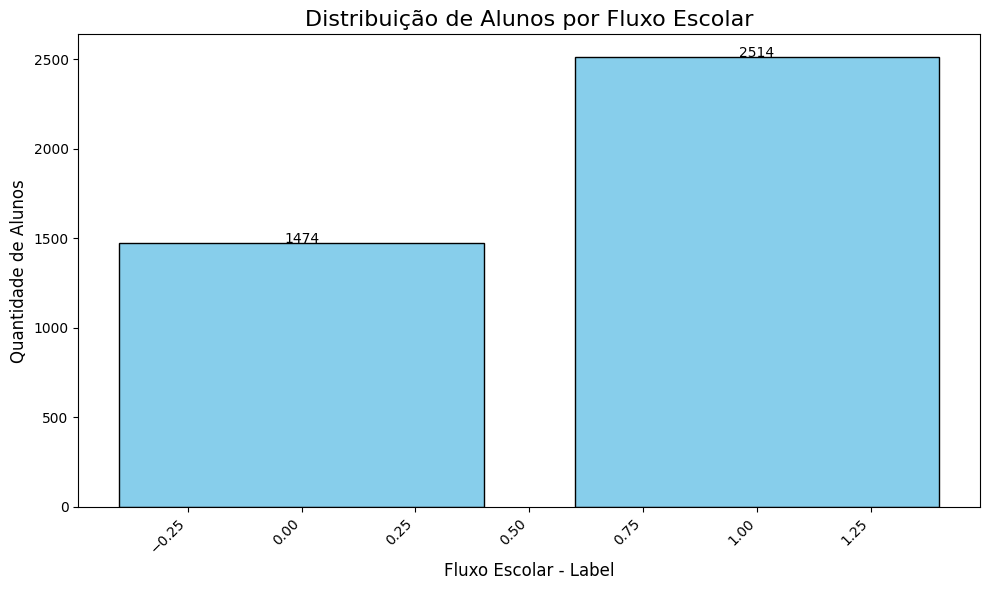

In [ ]:
df_grouped = df.groupby('Fluxo Escolar - Label').size().reset_index(name='Count')

plt.figure(figsize=(10, 6))

plt.bar(df_grouped['Fluxo Escolar - Label'], df_grouped['Count'], color='skyblue', edgecolor='black')

plt.title('Distribuição de Alunos por Fluxo Escolar', fontsize=16)
plt.xlabel('Fluxo Escolar - Label', fontsize=12)
plt.ylabel('Quantidade de Alunos', fontsize=12)

plt.xticks(rotation=45, ha='right')

for index, value in enumerate(df_grouped['Count']):
    plt.text(index, value + 0.1, str(value), ha='center', fontsize=10)

plt.tight_layout()

plt.show()


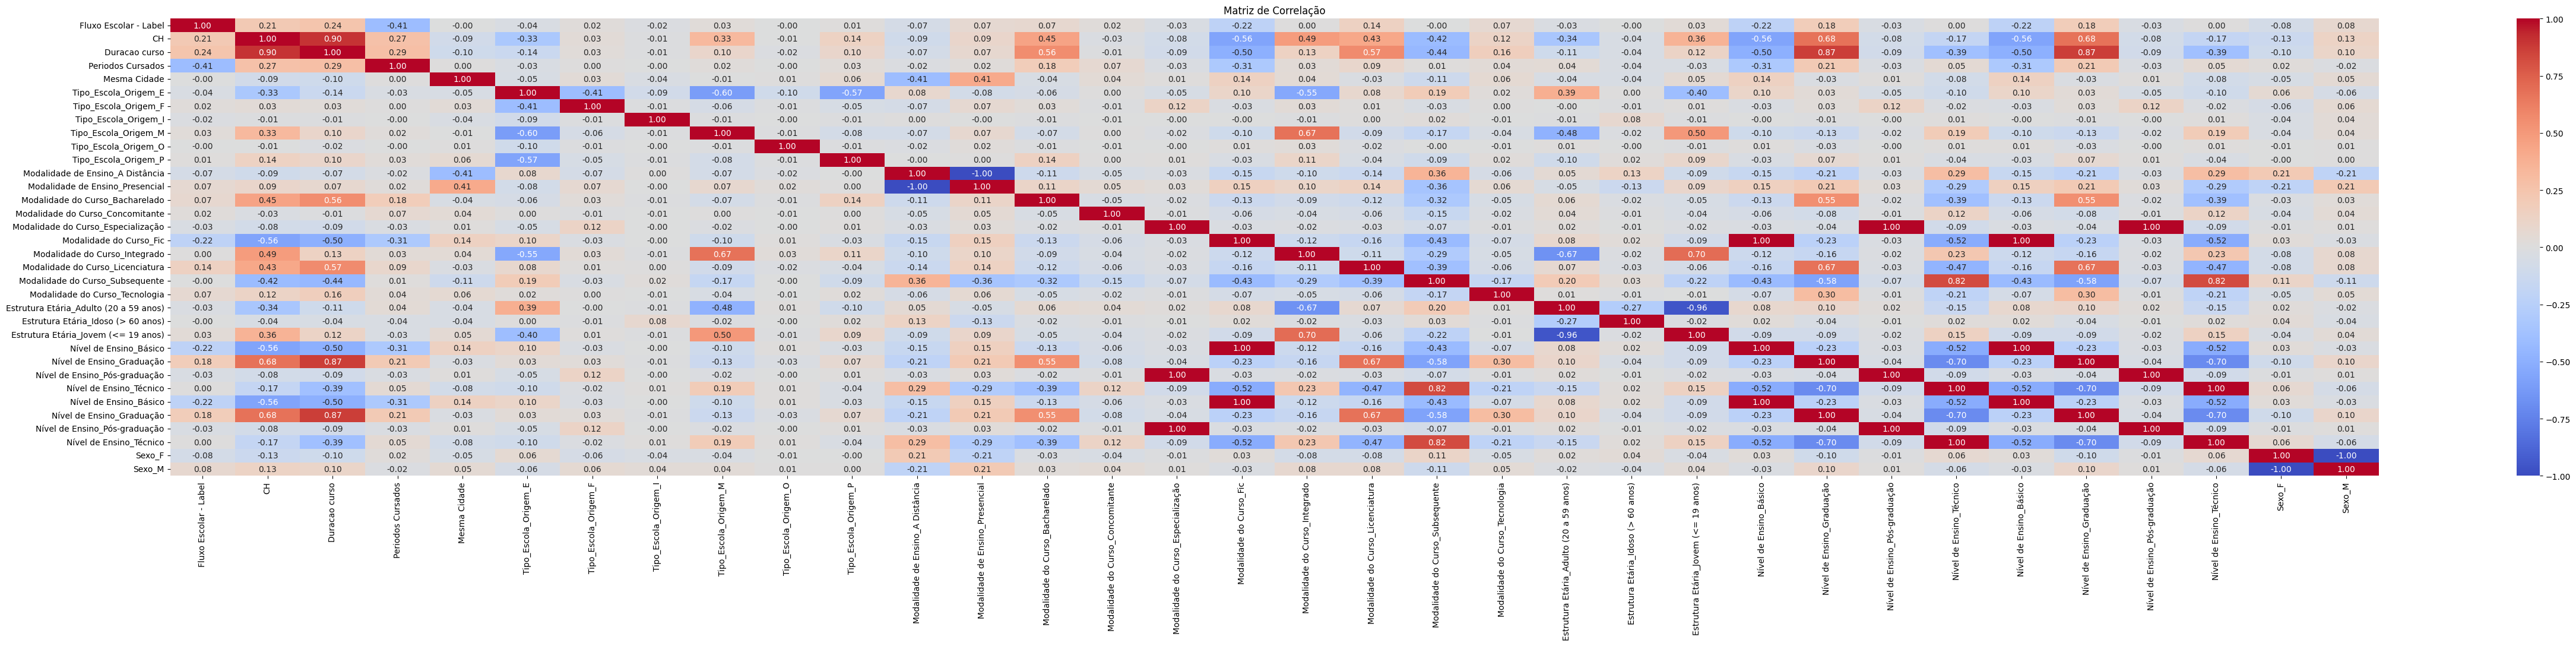

In [ ]:
correlation_matrix = df.corr()


plt.figure(figsize=(60, 10))


sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)



plt.title('Matriz de Correlação')
plt.show()

In [ ]:
df.groupby('Fluxo Escolar - Label').size().reset_index(name='Count')

,Fluxo Escolar - Label,Count
0,0,1474
1,1,2514


# Treino

In [ ]:
x = df.drop('Fluxo Escolar - Label', axis=1)
y = df['Fluxo Escolar - Label']

print(df.shape[0])


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print((len(x_train)))
print((len(y_train)))
print((len(x_test)))
print((len(y_test)))

print(len(x))
model = RandomForestClassifier()


model.fit(x, y)

y_pred = model.predict(x_test)




3988
2791
2791
1197
1197
3988


In [ ]:

accuracy = accuracy_score(y_test, y_pred)
evadidos = (y_pred == 1).sum()
nao_evadidos = (y_pred == 0).sum()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       432
           1       0.96      0.88      0.92       765

    accuracy                           0.90      1197
   macro avg       0.89      0.91      0.89      1197
weighted avg       0.91      0.90      0.90      1197



# Resultado

In [ ]:


accuracy = accuracy_score(y_test, y_pred)
evadidos = (y_pred == 1).sum()
nao_evadidos = (y_pred == 0).sum()
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.81      0.94      0.87       432
           1       0.96      0.88      0.92       765

    accuracy                           0.90      1197
   macro avg       0.89      0.91      0.89      1197
weighted avg       0.91      0.90      0.90      1197



In [ ]:
df.shape[0]

3988

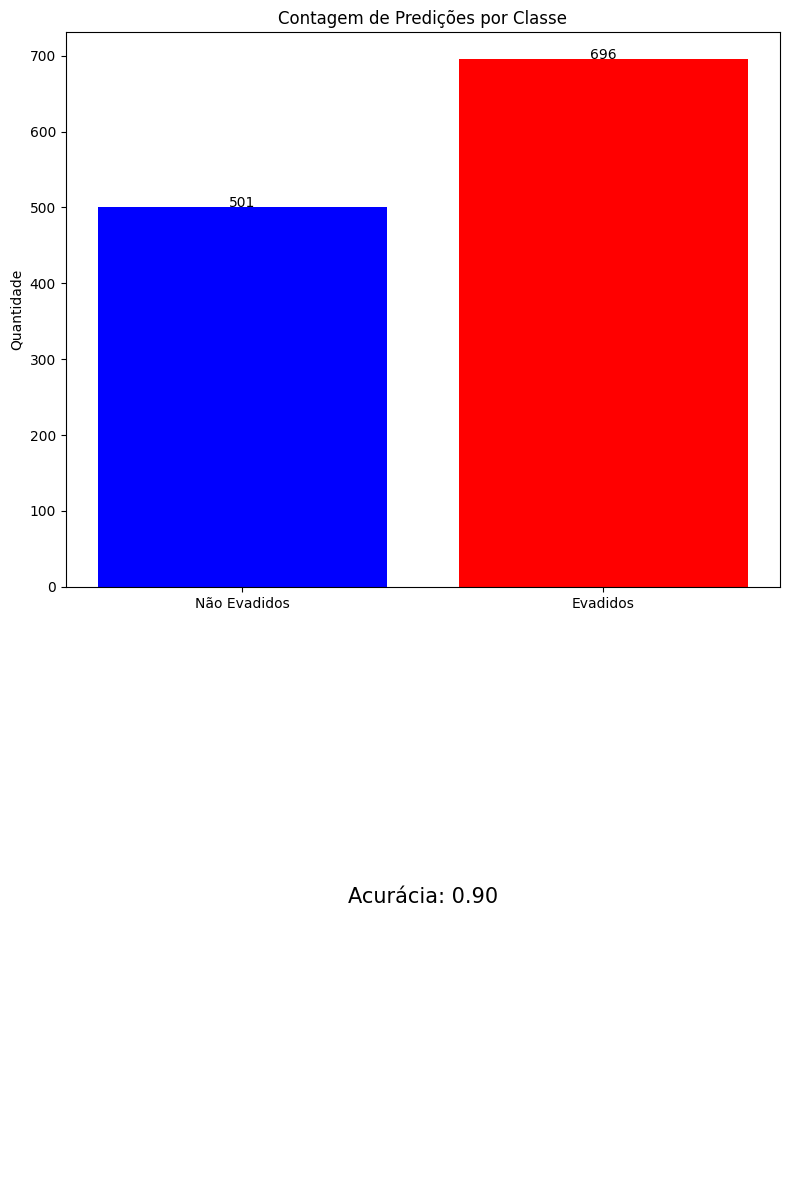

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))

labels = ['Não Evadidos', 'Evadidos']
values = [nao_evadidos, evadidos]
ax[0].bar(labels, values, color=['blue', 'red'])
ax[0].set_title('Contagem de Predições por Classe')
ax[0].set_ylabel('Quantidade')
for i, v in enumerate(values):
    ax[0].text(i, v + 0.2, str(v), color='black', ha='center')


ax[1].text(0.5, 0.5, f'Acurácia: {accuracy:.2f}', fontsize=15, ha='center')
ax[1].axis('off')

plt.tight_layout()
plt.show()

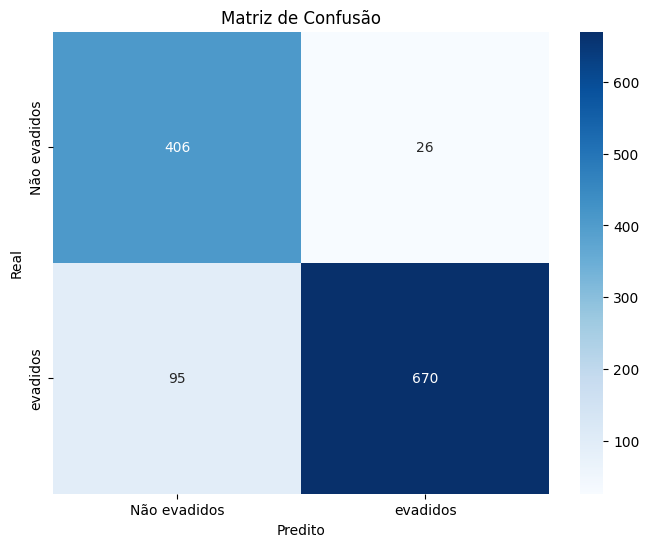

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não evadidos', 'evadidos'],
            yticklabels=['Não evadidos', 'evadidos'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


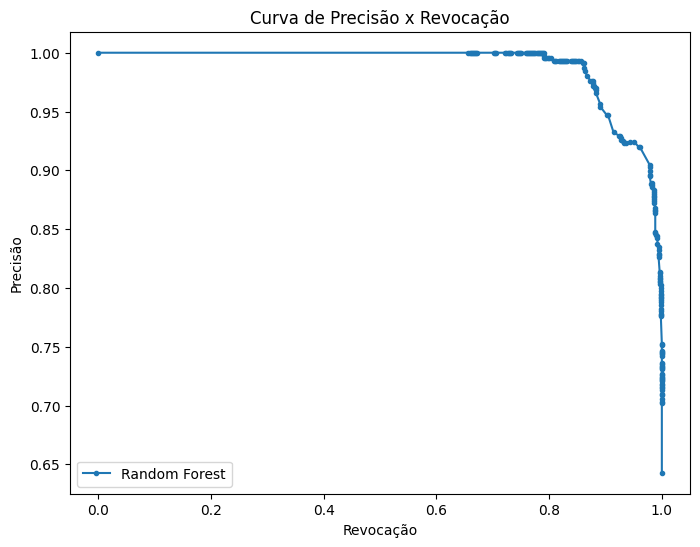

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score


y_probs = model.predict_proba(x_test)[:, 1]


precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Revocação')
plt.ylabel('Precisão')
plt.title('Curva de Precisão x Revocação')
plt.legend()
plt.show()


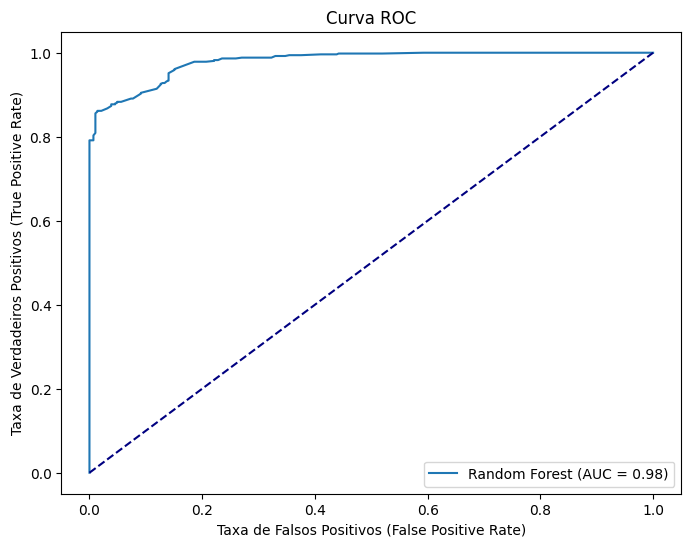

In [ ]:

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC')
plt.legend()
plt.show()
